<a href="https://colab.research.google.com/github/Sanugiw/CNN-for-Image-Classification/blob/main/Realwaste_team_Obscura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Setting up dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
from pathlib import Path
import cv2
from google.colab import drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
DATASET_PATH = '/content/drive/MyDrive/realwaste/RealWaste'  # Adjust this path
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 20


In [5]:
def load_dataset(dataset_path, img_height=128, img_width=128):
    """
    Load images from the RealWaste dataset structure
    Assumes structure: dataset_path/class_name/images
    """
    images = []
    labels = []
    class_names = []

    # Get all class folders
    class_folders = [f for f in os.listdir(dataset_path)
                     if os.path.isdir(os.path.join(dataset_path, f))]
    class_folders.sort()
    class_names = class_folders

    print(f"Found {len(class_names)} classes: {class_names}")

    # Load images from each class
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_path, class_name)
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        print(f"Loading {len(image_files)} images from class '{class_name}'...")

        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            try:
                # Read and resize image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    images = np.array(images, dtype='float32') / 255.0  # Normalize to [0,1]
    labels = np.array(labels)

    print(f"\nTotal images loaded: {len(images)}")
    print(f"Image shape: {images[0].shape}")
    print(f"Number of classes: {len(class_names)}")

    return images, labels, class_names


In [6]:
# Load the dataset
X, y, class_names = load_dataset(DATASET_PATH, IMG_HEIGHT, IMG_WIDTH)
num_classes = len(class_names)

# ============================================================================
# PART 3: TRAIN-VALIDATION-TEST SPLIT (70%-15%-15%)
# ============================================================================

# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test (50-50 split of the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


Found 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Loading 469 images from class 'Cardboard'...
Loading 411 images from class 'Food Organics'...
Loading 420 images from class 'Glass'...
Loading 790 images from class 'Metal'...
Loading 495 images from class 'Miscellaneous Trash'...
Loading 500 images from class 'Paper'...
Loading 921 images from class 'Plastic'...
Loading 318 images from class 'Textile Trash'...
Loading 436 images from class 'Vegetation'...

Total images loaded: 4760
Image shape: (128, 128, 3)
Number of classes: 9


In [7]:
print(f"\nDataset Split:")
print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")


Dataset Split:
Training set: 3332 images (70.0%)
Validation set: 714 images (15.0%)
Test set: 714 images (15.0%)


In [8]:
# Convert labels to categorical
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [9]:
def build_custom_cnn(input_shape, num_classes):


    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                      input_shape=input_shape, name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Flatten and Fully Connected Layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model

In [10]:
# Create the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
custom_model = build_custom_cnn(input_shape, num_classes)

print("\n" + "="*70)
print("CUSTOM CNN MODEL ARCHITECTURE")
print("="*70)
custom_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



CUSTOM CNN MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,409,289 (32.08 MB)

 Trainable params: 8,409,289 (32.08 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define optimizer
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate=learning_rate)

def train_model(model, optimizer, X_train, y_train,
                X_val, y_val, epochs=20):
    """
    Train the model with Adam optimizer
    """
    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    callbacks = []
    # Train
    print(f"\nTraining with Adam optimizer...")
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return history

In [15]:
# Create and train model
print(f"\n{'='*70}")
print(f"TRAINING WITH ADAM OPTIMIZER")
print(f"{'='*70}")

# Create model
model = build_custom_cnn(input_shape, num_classes)

# Train
history = train_model(model, optimizer, X_train, y_train_cat,
                     X_val, y_val_cat, epochs=EPOCHS)



TRAINING WITH ADAM OPTIMIZER

Training with Adam optimizer...
Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.1655 - loss: 2.8160 - val_accuracy: 0.3459 - val_loss: 1.8959
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2946 - loss: 1.9088 - val_accuracy: 0.4076 - val_loss: 1.6365
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3840 - loss: 1.6728 - val_accuracy: 0.4202 - val_loss: 1.5949
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4338 - loss: 1.5539 - val_accuracy: 0.4804 - val_loss: 1.3841
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4970 - loss: 1.3947 - val_accuracy: 0.5266 - val_loss: 1.2861
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5369 - loss: 1.2354 - val_accuracy: 0.5042 - val_loss: 1.2679
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5754 - loss: 1.1269 - val_accuracy: 0.5420 - val_loss: 1.2302
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━


PLOTTING TRAINING RESULTS


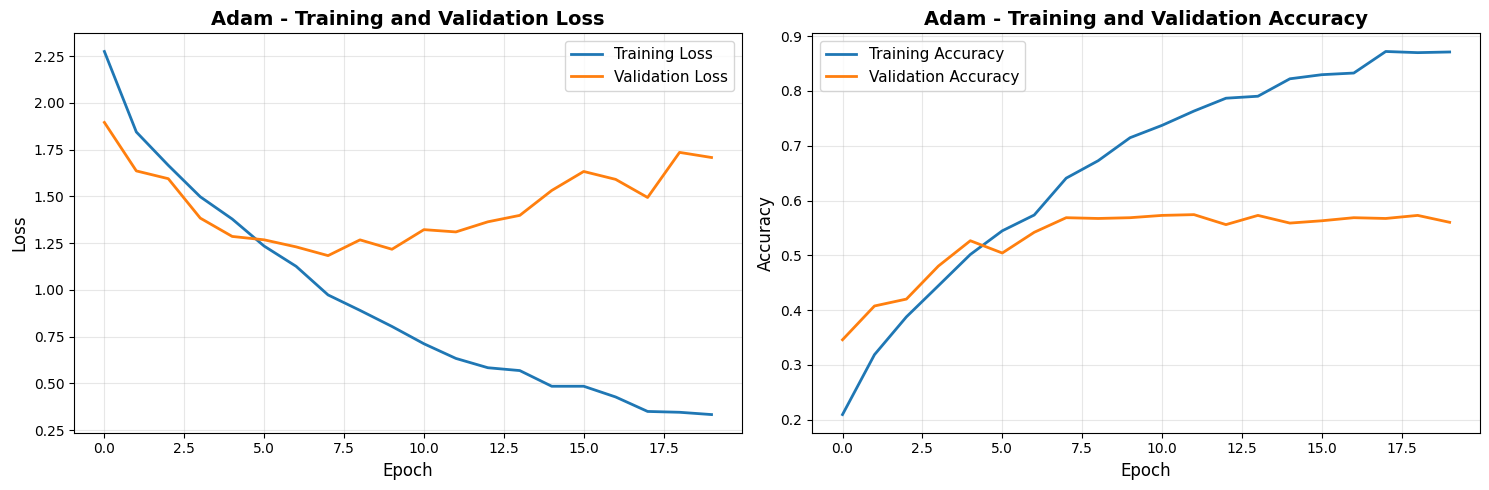

✓ Training plots saved


In [16]:
# ============================================================================
# PLOTTING TRAINING RESULTS
# ============================================================================

print("\n" + "="*70)
print("PLOTTING TRAINING RESULTS")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Adam - Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Adam - Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_adam.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Training plots saved")


MODEL EVALUATION

Train Accuracy: 0.9958
Test Accuracy: 0.5714
Train Loss: 0.0494
Test Loss: 1.7254

Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.59      0.54      0.57        70
      Food Organics       0.64      0.48      0.55        61
              Glass       0.78      0.63      0.70        63
              Metal       0.53      0.66      0.59       119
Miscellaneous Trash       0.41      0.45      0.43        75
              Paper       0.54      0.44      0.49        75
            Plastic       0.61      0.60      0.61       138
      Textile Trash       0.46      0.27      0.34        48
         Vegetation       0.60      0.91      0.72        65

           accuracy                           0.57       714
          macro avg       0.58      0.55      0.56       714
       weighted avg       0.58      0.57      0.57       714



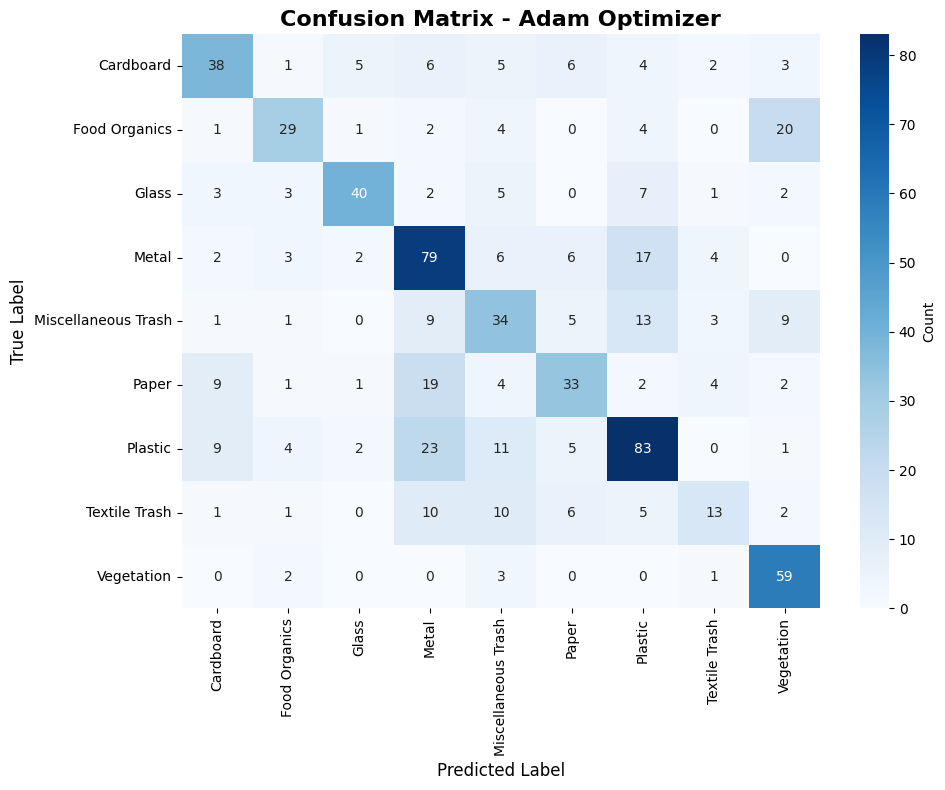

✓ Confusion matrix saved

PERFORMANCE SUMMARY
Optimizer  Train Accuracy  Train Loss  Test Accuracy  Test Loss  Precision   Recall  F1-Score
     Adam        0.995798    0.049408       0.571429   1.725443   0.576215 0.554485  0.555106

✓ Results saved to 'model_results.csv'


In [17]:
# ============================================================================
# EVALUATE MODEL
# ============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Get predictions
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate metrics
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)

# Print results
print(f"\nTrain Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

report = classification_report(y_test, y_pred,
                               target_names=class_names,
                               output_dict=True)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Adam Optimizer', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_adam.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Confusion matrix saved")

# Create results summary
results_data = {
    'Optimizer': 'Adam',
    'Train Accuracy': train_acc,
    'Train Loss': train_loss,
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Precision': report['macro avg']['precision'],
    'Recall': report['macro avg']['recall'],
    'F1-Score': report['macro avg']['f1-score']
}

# Create DataFrame
results_df = pd.DataFrame([results_data])

print("\n" + "="*70)
print("PERFORMANCE SUMMARY")
print("="*70)
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('model_results.csv', index=False)
print("\n✓ Results saved to 'model_results.csv'")

In [22]:
# ============================================================================
# SAVE MODEL
# ============================================================================

print("\n" + "="*70)
print("SAVING MODEL")
print("\n" + "="*70)

# Save model
model.save('/content/drive/MyDrive/realwaste/model.h5')
print(f"✓ Adam model saved")

print("\n" + "="*70)
print("TRAINING AND EVALUATION COMPLETE!")
print("\n" + "="*70)
print("\nGenerated Files:")
print("  - training_adam.png (Loss and Accuracy plots)")
print("  - confusion_matrix_adam.png")
print("  - model_results.csv")
print("  - model_adam.h5 (Saved model)")



SAVING MODEL

✓ Adam model saved

TRAINING AND EVALUATION COMPLETE!


Generated Files:
  - training_adam.png (Loss and Accuracy plots)
  - confusion_matrix_adam.png
  - model_results.csv
  - model_adam.h5 (Saved model)


In [23]:
import shutil
from google.colab import files

# Save model
model.save('model_adam.h5')

# Compress it
shutil.make_archive('model_adam', 'zip', '.', 'model_adam.h5')

# Download the zip file
files.download('model_adam.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>